# **Exercie 1**

## **Importer les librairies**

In [3]:
# Importer les librairies
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import (
    to_categorical,
    set_random_seed,
    image_dataset_from_directory,
    load_img,
    array_to_img,
    img_to_array
)

from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## **Charger et explorer le jeu de données**

Pour rendre le code exportable, le dataset est téléhargé dépuis Kaggle en utilisant la librairie kagglehub

In [4]:
# Installation de la librairie
!pip install kagglehub
import kagglehub

In [5]:
# Data loading

path = kagglehub.dataset_download("antobenedetti/animals")
print("Path to dataset files:", path)

100%|██████████| 882M/882M [00:42<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/antobenedetti/animals/versions/5


In [6]:
kagglehub_path = "/root/.cache/kagglehub/datasets/antobenedetti/animals/versions/5/animals"
kaggle_input_path = "/kaggle/input/animals"

if os.path.exists(kagglehub_path):
    DATASET = kagglehub_path
elif os.path.exists(kaggle_input_path):
    DATASET = kaggle_input_path
else:
    raise FileNotFoundError("Dataset introuvable dans les chemins spécifiés.")

print("Dataset utilisé :", DATASET)
print(os.listdir(DATASET))

Dataset utilisé : /root/.cache/kagglehub/datasets/antobenedetti/animals/versions/5/animals
['inf', 'val', 'train']


In [7]:
# afin de rendre les résultats réproductible, un SEED est fixé
SEED = 42
BATCH_SIZE = 42   # nombre d'images traitées en même temps avant une mise à jour
IMAGE_SIZE = (224, 224)  # taille des images après augmentation

### Fonction utilitaire pour le chargement des données


In [8]:
def load_dataset(path, subset=None, validation_split=None,
                 batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, seed=SEED, ignore_errors=True):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='int',
        validation_split=validation_split,
        subset=subset,
        image_size=IMAGE_SIZE,
        interpolation='lanczos5',
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )

### Fonction utilitaire pour l'optimisation du pipeline de données dans ensorFlow


In [9]:
def prepare_dataset(train_dataset, val_dataset=None, shuffle_buffer=1000, autotune=True):
    """
    Prépare les datasets TensorFlow (train et val) avec cache, shuffle et prefetch.

    Args:
        train_dataset (tf.data.Dataset): dataset d'entraînement
        val_dataset (tf.data.Dataset, optional): dataset de validation
        shuffle_buffer (int): taille du buffer pour le mélange aléatoire
        autotune (bool): tf.data.AUTOTUNE pour le prefetch

    Returns:
        (train_dataset, val_dataset): datasets optimisés.
    """
    AUTOTUNE = tf.data.AUTOTUNE if autotune else None

    # Préparation des données d'entraînement
    train_dataset = train_dataset.cache().shuffle(shuffle_buffer).prefetch(buffer_size=AUTOTUNE)

    # Préparation des données de validation si fourni
    if val_dataset is not None:
        val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Nettoyage mémoire avant entraînement
    keras.backend.clear_session()

    return train_dataset, val_dataset

### Chargement des données

In [10]:
TRAIN = DATASET + "/train"
TEST = DATASET + "/val"
INF = DATASET + "/test"

print("Dataset utilisé :", DATASET)
print(os.listdir(DATASET))

Dataset utilisé : /root/.cache/kagglehub/datasets/antobenedetti/animals/versions/5/animals
['inf', 'val', 'train']


In [11]:
# séparation du jeu de données en train, val et test
train_dataset = load_dataset(TRAIN, subset='training', validation_split=0.2)
val_dataset   = load_dataset(TRAIN, subset='validation', validation_split=0.2)
test_dataset  = load_dataset(TEST, shuffle=False)

class_names = test_dataset.class_names
print("Classes:", class_names)


Found 13474 files belonging to 5 classes.
Using 10780 files for training.
Found 13474 files belonging to 5 classes.
Using 2694 files for validation.
Found 1497 files belonging to 5 classes.
Classes: ['cat', 'dog', 'elephant', 'horse', 'lion']


### Exploration du jeu de données

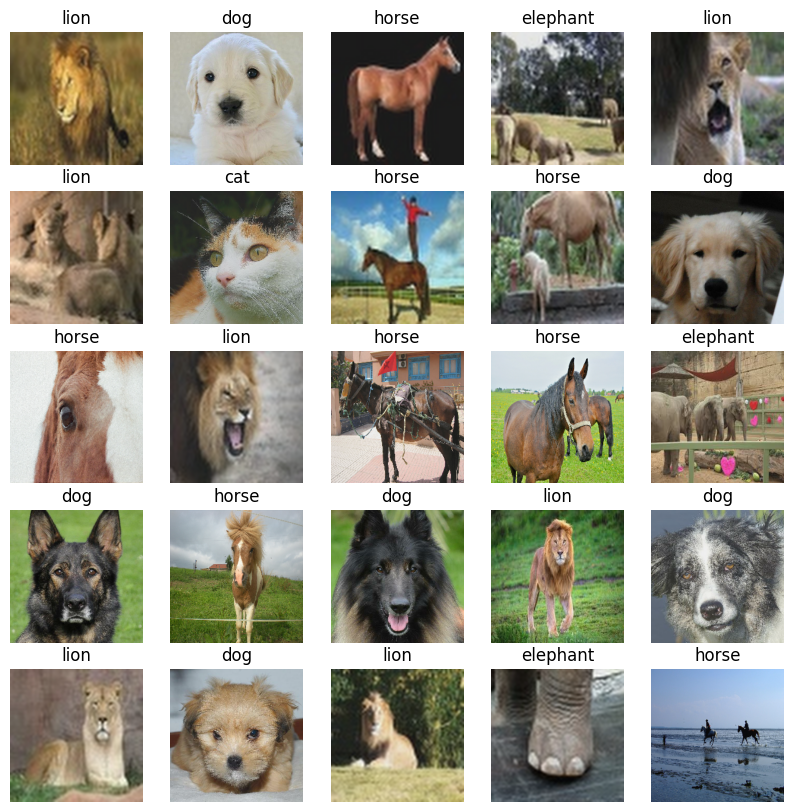

In [12]:
images, labels = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(array_to_img(images[i]))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


### Fonction utilitaire pour l'augmenttaion des données


In [13]:
def get_data_augmentation():
    return Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.25),
        layers.RandomZoom(0.15),
    ], name="data_augmentation")

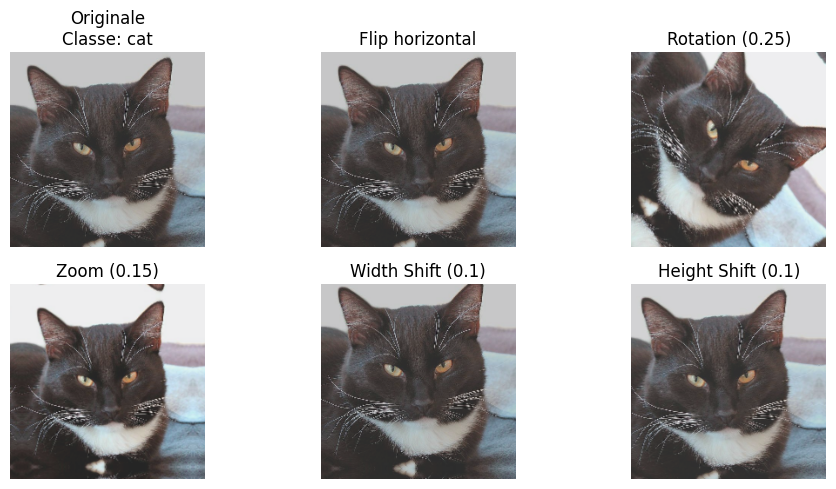

In [14]:
# Visualisation de l'augmentation
transformations = [
    ("Flip horizontal", Sequential([layers.RandomFlip("horizontal")])),
    ("Rotation (0.25)", Sequential([layers.RandomRotation(0.25)])),
    ("Zoom (0.15)", Sequential([layers.RandomZoom(0.15)])),
    ("Width Shift (0.1)", Sequential([layers.RandomTranslation(0.1, 0.0)])),
    ("Height Shift (0.1)", Sequential([layers.RandomTranslation(0.0, 0.1)]))
]


def visualize_individual_transforms(dataset, transformations, num_examples=None):
    # Prendre une image au hasard dans le dataset
    images, labels = next(iter(dataset))
    idx = np.random.randint(len(images))
    img = images[idx:idx+1]
    true_label = labels[idx].numpy()

    plt.figure(figsize=(10, 5))

    # Image originale
    plt.subplot(2, 3, 1)
    plt.imshow(array_to_img(img[0]))
    plt.title(f"Originale\nClasse: {class_names[true_label]}")
    plt.axis("off")

    # Appliquer chaque transformation
    for i, (name, aug) in enumerate(transformations, 2):
        augmented_img = aug(img, training=True)
        plt.subplot(2, 3, i)
        plt.imshow(array_to_img(augmented_img[0]))
        plt.title(name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_individual_transforms(train_dataset, transformations)


# **Architecture du CNN**

### Fonction utilitaire pour la construction du CNN


In [15]:
def build_cnn(input_shape, num_classes, data_augmentation=None):

    model = Sequential()

    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Conv2D(16, 3, padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(128, 3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D())

    #model.add(layers.Conv2D(256, 3, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    #model.add(layers.GlobalAveragePooling2D())
    #model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))

    return model

### Fonction utilitaire pour la compilation

In [16]:
LEARNING_RATE = 0.001
def compile_model(model, learning_rate=LEARNING_RATE):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model


### Résumé du modèle

In [17]:
data_aug = get_data_augmentation()
num_classes = len(class_names)
cnn_model = build_cnn(input_shape=(*IMAGE_SIZE, 3), num_classes=num_classes,  data_augmentation=data_aug)
cnn_model = compile_model(cnn_model)
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,561,765 (25.03 MB)

 Trainable params: 6,561,733 (25.03 MB)

 Non-trainable params: 32 (128.00 B)

### Fonction utilitaire pour entrainer le modèle

In [18]:
# Fonction pour entraîner le modèle
def train_model(model, train_dataset, val_dataset, epochs, min_delta, patience):
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=min_delta,
        patience=patience,
        verbose=0,
        mode='max',
        restore_best_weights=True
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        epochs=epochs
    )
    return history


 ### Fonction utilitaire pour plotter l'historique de l'entrainement

In [19]:
# Fonction pour afficher l'historique d'entraînement
def plot_training_history(history, patience):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_run = len(loss)
    epochs_range = range(1, epochs_run + 1)
    early_stop = epochs_run - patience

    plt.figure(figsize=(14, 5))

    # Courbes d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linestyle='-.', color='green')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='-.', color='blue')
    plt.plot(early_stop, val_acc[early_stop-1], 'ro', label='Restored best epoch')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Courbes de perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linestyle='-.', color='orange')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='-.', color='red')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()


 ### Fonction utilitaire pour faire de la prediction avec le modèle

In [20]:
def prediction(dataset, model, class_names, n_images=10, top_k=3):
    """
    Prédit et affiche les résultats d'un batch d'images d'un dataset TensorFlow,
    avec visualisation des top-k classes.

    Args:
        dataset (tf.data.Dataset): dataset contenant (images, labels)
        model (tf.keras.Model): modèle entraîné
        class_names (list): noms des classes
        n_images (int): nombre d'images à afficher (<= batch_size)
        top_k (int): nombre de classes à afficher dans le graphique
    """
    # Récupérer un batch
    images, labels = next(iter(dataset))
    preds = model.predict(images, verbose=0)

    # Limiter au nombre demandé
    n_images = min(n_images, len(images))

    plt.figure(figsize=(12, 2 * n_images))
    for i in range(n_images):
        true_label = class_names[labels[i].numpy()]
        top_idx = np.argsort(preds[i])[-top_k:][::-1]   # indices des top-k
        top_probs = preds[i][top_idx]
        top_labels = [class_names[j] for j in top_idx]

        # Image
        plt.subplot(n_images, 2, 2*i + 1)
        plt.imshow(array_to_img(images[i]))
        plt.axis("off")
        pred_label = class_names[top_idx[0]]
        confidence = top_probs[0] * 100
        plt.title(f"Prédit: {pred_label} ({confidence:.1f}%)\nRéalité: {true_label}", fontsize=9)

        # Graphique barres top-k
        plt.subplot(n_images, 2, 2*i + 2)
        bars = plt.barh(top_labels, top_probs * 100, color='mediumseagreen')
        plt.xlim(0, 100)
        plt.xlabel("Confidence (%)")
        plt.gca().invert_yaxis()
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                     f"{width:.1f}%", va='center', fontsize=8)

    plt.tight_layout()
    plt.show()


# Entrainer et tester le modèle

### Entrainement


In [21]:
EPOCHS = 100
PATIENCE = 15
MIN_DELTA = 0.01

In [22]:
history = train_model(cnn_model, train_dataset, val_dataset, epochs=EPOCHS, min_delta=MIN_DELTA, patience=PATIENCE)

Epoch 1/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 86s 306ms/step - accuracy: 0.2861 - loss: 1.6231 - val_accuracy: 0.2584 - val_loss: 1.7880
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 135s 296ms/step - accuracy: 0.5114 - loss: 1.1730 - val_accuracy: 0.5943 - val_loss: 0.9706
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 76s 272ms/step - accuracy: 0.6322 - loss: 0.9048 - val_accuracy: 0.6076 - val_loss: 1.0867
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 70s 273ms/step - accuracy: 0.6892 - loss: 0.7856 - val_accuracy: 0.6730 - val_loss: 0.8431
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 89s 299ms/step - accuracy: 0.7271 - loss: 0.7148 - val_accuracy: 0.7580 - val_loss: 0.6187
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 74s 266ms/step - accuracy: 0.7502 - loss: 0.6555 - val_accuracy: 0.7064 - val_loss: 0.8206
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 91s 303ms/step - accuracy: 0.7629 - loss: 0.6264 - val_accuracy: 0.7647 - val_loss: 0.6325
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 69s 268ms/step - accuracy: 0.7881 

### Évaluation

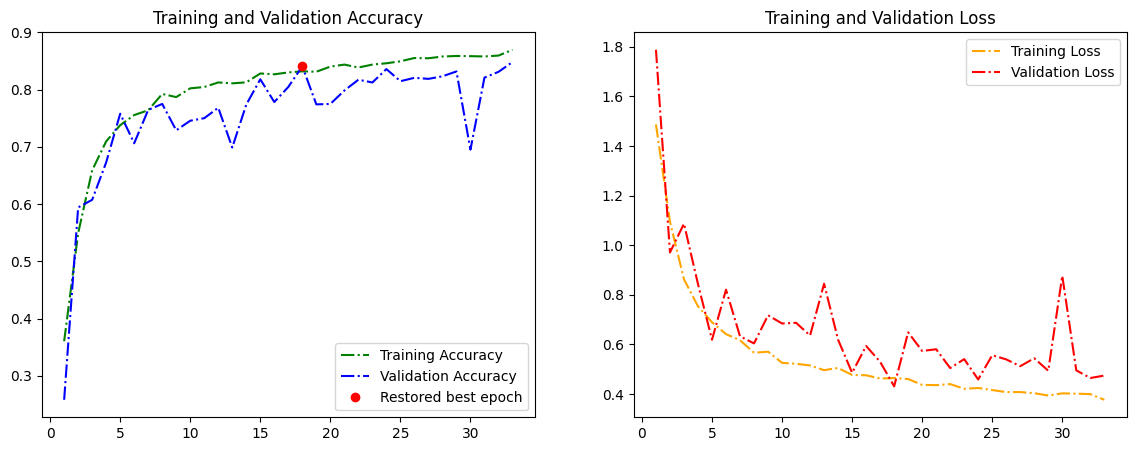

In [23]:
plot_training_history(history, patience=PATIENCE)

In [24]:
print("\nEvaluation sur le dataset de test :")
test_loss, test_acc = cnn_model.evaluate(test_dataset, verbose=2)
print(f"Test accuracy: {test_acc*100:.2f}%")


Evaluation sur le dataset de test :
36/36 - 6s - 177ms/step - accuracy: 0.8510 - loss: 0.4079
Test accuracy: 85.10%


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step


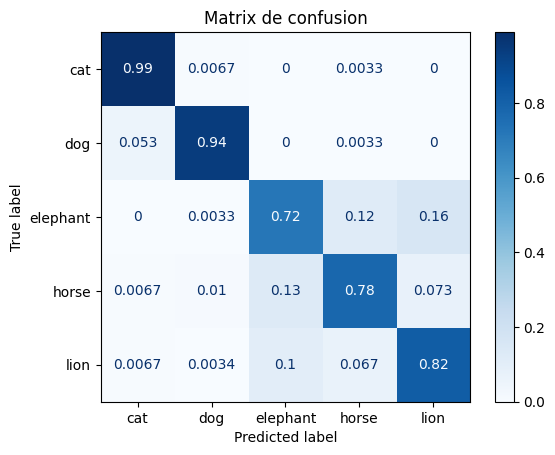

In [25]:
# Matrice de confusion normalisée
test_labels = np.concatenate([y for _, y in test_dataset], axis=0)
predictions = cnn_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

disp = ConfusionMatrixDisplay.from_predictions(
        test_labels, predicted_labels,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true'
)
disp.ax_.set_title('Matrix de confusion')
plt.show()

### Prédiction sur de nouvelles nouvelles

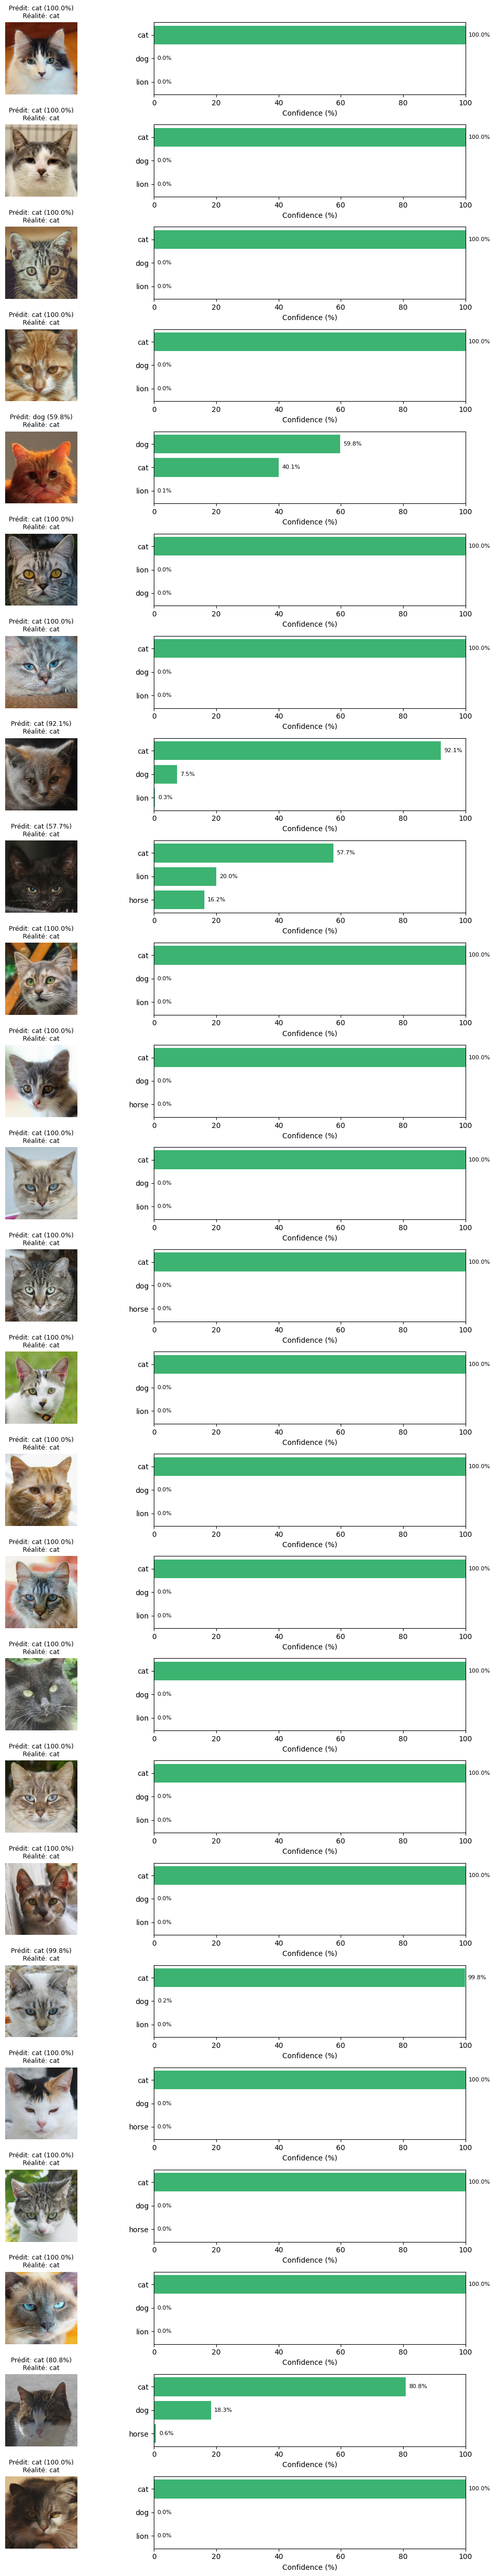

In [26]:
prediction(test_dataset, cnn_model, class_names, n_images=25)